In [1]:
import json
import pandas as pd
import numpy as np
import os  # hỗ trợ thực hiện các thao tác liên quan đến hệ điều hành.
import glob  

import warnings

# Data modeling
import torch
from sentence_transformers import SentenceTransformer

# Data cleaning
import nltk
from nltk.corpus import stopwords
import re
import string
import emoji
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.tag import pos_tag

# Reduce data dimensionality
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Data clustering
from sklearn.cluster import KMeans

# Cluster evaluation
# Cluster evaluation
from sklearn.metrics import calinski_harabasz_score
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

# Topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

C:\Users\Long\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [33]:
warnings.filterwarnings("ignore")

# 1. Read user posts data from folder

In [33]:
directory = r'D:\lap trinh\data for analyst\Data_NCKH\All_data'

# Tạo danh sách để lưu các DataFrame
dataframes = []

# Duyệt qua các file trong thư mục
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        file_path = os.path.join(directory, filename)
        
        # Đọc file JSON
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            
            # Chuyển đổi dữ liệu JSON thành DataFrame
            df = pd.json_normalize(data)
            
            # Thêm cột 'source_file' với tên của file hiện tại
            df['source_file'] = filename
            
            # Thêm DataFrame vào danh sách
            dataframes.append(df)
        except json.JSONDecodeError:
            print(f"Lỗi đọc file JSON: {file_path}")
        except Exception as e:
            print(f"Lỗi khác: {file_path}, lỗi: {e}")

# Gộp tất cả các DataFrame thành một DataFrame
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)

Lỗi đọc file JSON: D:\lap trinh\data for analyst\Data_NCKH\All_data\taylorswift_facebook_6.json


In [43]:
df.head()

,post_id,text,post_text,shared_text,original_text,time,timestamp,image,image_lowquality,images,...,page_id,sharers,image_id,image_ids,was_live,header,source_file,listing_title,listing_price,listing_location
0,682254716601826,Feliz aniversário pra vc minha mãe... sentimos...,Feliz aniversário pra vc minha mãe... sentimos...,,Feliz aniversário pra vc minha mãe... sentimos...,2022-09-30 08:15:39,1.664501e+09,None,https://scontent.fsgn5-2.fna.fbcdn.net/v/t39.3...,None,...,142523572511686,None,682254693268495,[682254693268495],False,NaN,10Ronaldinho_facebook_1.json,NaN,NaN,NaN
1,681088063385158,Meu primeiro gol por este gigante que é o AC M...,Meu primeiro gol por este gigante que é o AC M...,,Meu primeiro gol por este gigante que é o AC M...,2022-09-28 20:52:45,1.664373e+09,None,https://scontent.fsgn5-11.fna.fbcdn.net/v/t39....,None,...,142523572511686,None,None,[],False,NaN,10Ronaldinho_facebook_1.json,NaN,NaN,NaN
2,680381473455817,Hj é nosso último passo antes da Copa do Mundo...,Hj é nosso último passo antes da Copa do Mundo...,,Hj é nosso último passo antes da Copa do Mundo...,2022-09-27 22:54:04,1.664294e+09,None,https://scontent.fsgn5-14.fna.fbcdn.net/v/t39....,None,...,142523572511686,None,680381320122499,[680381320122499],False,NaN,10Ronaldinho_facebook_1.json,NaN,NaN,NaN
3,679750666852231,Once upon a time at AC Milan ✨\n\n#UCL,Once upon a time at AC Milan ✨\n\n#UCL,,None,2022-09-27 02:47:24,1.664222e+09,None,https://scontent.fsgn5-6.fna.fbcdn.net/v/t39.3...,None,...,142523572511686,None,6304396786273397,[6304396786273397],False,Ronaldinho Gaúcho,10Ronaldinho_facebook_1.json,NaN,NaN,NaN
4,676457457181552,Parabéns xará… merece tudo de melhor sempre 👏🏾...,Parabéns xará… merece tudo de melhor sempre 👏🏾...,,Parabéns xará… merece tudo de melhor sempre 👏🏾...,2022-09-23 00:08:51,1.663867e+09,None,https://scontent.fsgn5-5.fna.fbcdn.net/v/t39.3...,None,...,142523572511686,None,676457360514895,[676457360514895],False,NaN,10Ronaldinho_facebook_1.json,NaN,NaN,NaN


## 1.1. Format the data

In [67]:
df = df[["source_file","post_text"]]
df["source_file"] = df["source_file"].apply(lambda x:x[:-7])

In [69]:
df.head()

,source_file,post_text
0,10Ronaldinho_facebook,Feliz aniversário pra vc minha mãe... sentimos...
1,10Ronaldinho_facebook,Meu primeiro gol por este gigante que é o AC M...
2,10Ronaldinho_facebook,Hj é nosso último passo antes da Copa do Mundo...
3,10Ronaldinho_facebook,Once upon a time at AC Milan ✨\n\n#UCL
4,10Ronaldinho_facebook,Parabéns xará… merece tudo de melhor sempre 👏🏾...


In [85]:
df_group_user = df.groupby('source_file')['post_text'].agg(' '.join).reset_index()
df_group_user.head(10)

,source_file,post_text
0,10Ronaldinho_facebook,Feliz aniversário pra vc minha mãe... sentimos...
1,143redangel_facebook,Top Rating and Phenomenal! Tatak Angel Locsin ...
2,50cent_facebook,yeah Sweden was lit 🔥we gonna see what’s up wi...
3,5SOS_facebook,#5SOS5 MERCH IS HERE ✨🖤 grab yours now!!\n\n5S...
4,ABdeVilliers17_facebook,Flipkart’s Big Billion Days sale is here! Get ...
5,ActuallyNPH_facebook,"Oh, hi there. Here’s me, sipping whisky in Sco..."
6,Adele_facebook,ELLE UK ELLE US Words can’t explain how ecstat...
7,AnnaKendrick47_facebook,Did you like my Super Bowl commercial with Bar...
8,AnushkaSharma_facebook,Love Lavie handbags.\nVibrant hues for every m...
9,Ashton5SOS_facebook,2 Year Anniversary of Superbloom. kicking it b...


# 2. Data post cleanning

## 2.1. Eliminate adverbs, quantifiers words

In [77]:
# Loại mấy từ không có nghĩa
time_adverbs = [
    "now", "time","year","month","week","weekend","day","hour","minute","second","today", "tonight", "yesterday", "tomorrow", "last night",
    "this morning", "this afternoon", "this evening", "next week",
    "last week", "next month", "last month", "currently", "recently",
    "lately", "soon", "early", "late", "before", "after", "soon", "already",
    "recently", "recently", "just", "yet", "still", "so far", "up to now",
    "since", "recently", "ever", "never", "always", "sometimes", "often",
    "frequently", "occasionally", "rarely", "seldom", "usually", "generally",
    "regularly", "daily", "weekly", "monthly", "yearly", "annually",  "absolutely", "actually", "almost", "always", "apparently", "approximately",
    "badly", "basically", "carefully", "certainly", "clearly", "completely",
    "constantly", "definitely", "easily", "effectively", "entirely", "especially",
    "eventually", "exactly", "extremely", "fairly", "finally", "frequently",
    "generally", "gently", "hardly", "hopefully", "immediately", "initially",
    "nearly", "necessarily", "normally", "obviously", "occasionally", "often",
    "particularly", "perfectly", "personally", "possibly", "practically",
    "presumably", "previously", "probably", "promptly", "quite", "rapidly",
    "really", "recently", "relatively", "safely", "seemingly", "seriously",
    "significantly", "simply", "slightly", "slowly", "suddenly", "surely",
    "technically", "thoroughly", "totally", "truly", "typically", "ultimately",
    "usually", "utterly", "virtually", "well", "widely"
]
quantifiers =[ "some", "many", "much", "any", "few", "several", "a few", "a lot",
    "a great deal", "plenty", "most", "more", "less", "enough", "too much",
    "too little", "all", "none", "each", "every", "either", "neither",
    "both", "half", "whole", "part", "somebody", "someone", "something",
    "nobody", "no one", "nothing", "anybody", "anyone", "anything",
    "everybody", "everyone", "everything", "few people", "a few people",
    "many people", "several people", "most people", "some people",
    "no people", "everybody", "everyone", "everything"]
def post_cleanning_Nomeaningword(text):

    text = str(text)

    list_Nonemeaningword = [word for word in text.split(' ') if word not in time_adverbs]
    cleaned_text = ' '.join(list_Nonemeaningword)

    list_Nonemeaningword = [word for word in cleaned_text.split(' ') if word not in quantifiers]
    cleaned_text = ' '.join(list_Nonemeaningword)
    return cleaned_text.strip()

## 2.2. Eliminate stop words, links, symbols, emojis... And Stemming words

In [79]:
# CLEARMEN CR7
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Tải danh sách stop word tiếng Anh
nltk.download('stopwords')
# Lấy danh sách stop word tiếng Anh
stop_words = set(stopwords.words('english'))

stemmer = nltk.SnowballStemmer('english', 'spain')

def post_cleanning(text):

    text = str(text)

    # Loại bỏ đường link
    link_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    cleaned_text = re.sub(link_pattern, "", text)

    # Chỉ giữ lại các danh từ, và tên riêng
    words = word_tokenize(cleaned_text)
    tagged_words = pos_tag(words)
    desired_tags = ['NN', 'NNS','NNP']
    nouns = [word for word, tag in tagged_words if tag in desired_tags]
    cleaned_text = ' '.join(nouns)

    list_Nonemeaningword = [word for word in cleaned_text.split(' ') if word not in [time_adverbs,quantifiers]]
    cleaned_text = ' '.join(list_Nonemeaningword)

    # Chuyển đổi văn bản thành chữ thường
    cleaned_text = str(cleaned_text).lower()

    # Loại bỏ các ký tự trong dấu ngoặc vuông
    cleaned_text = re.sub('\[.*?\]', '', cleaned_text)

    # Loại bỏ các thẻ HTML
    cleaned_text = re.sub('<.*?>+', '', cleaned_text)

    # Loại bỏ các dấu câu
    cleaned_text = re.sub('[%s]' % re.escape(string.punctuation), '', cleaned_text)

    # Loại bỏ các từ có chứa số
    cleaned_text = re.sub('\w*\d\w*', '', cleaned_text)

    # Loại bỏ emoji
    cleaned_text = emoji.replace_emoji(cleaned_text)

    # Loại bỏ stop word
    list_Nonestopword = [word for word in cleaned_text.split(' ') if word not in stop_words]
    cleaned_text = ' '.join(list_Nonestopword)

    # Stemming từ
    list_stemmingword = [stemmer.stem(word) for word in cleaned_text.split(' ')]
    cleaned_text = ' '.join(list_stemmingword)

    return cleaned_text.strip()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Long\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Long\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Long\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
# xóa dòng rỗng
df_group_user = df_group_user[df_group_user['post_text'].astype(str).str.contains(r'[a-zA-Z]', na=False)].reset_index(drop=True)
len(df_group_user)

303

In [89]:
# làm sạch
df_group_user["post_text"] = df_group_user["post_text"].apply(post_cleanning)

In [90]:
# loại bỏ các trạng từ chỉ thời gian
df_group_user["post_text"] = df_group_user["post_text"].apply(post_cleanning_Nomeaningword)

In [91]:
df_group_user = df_group_user[df_group_user['post_text'].astype(str).str.contains(r'[a-zA-Z]', na=False)].reset_index(drop=True)

In [97]:
df_group_user.head(10)

,source_file,post_text
0,10Ronaldinho_facebook,feliz aniversário pra vc minha mãe sua falta t...
1,143redangel_facebook,rate phenomen tatak angel locsin angel neil ’...
2,50cent_facebook,sweden gon germani tonightglggreenlightgang wo...
3,5SOS_facebook,merch grab love amazon music silver line gol...
4,ABdeVilliers17_facebook,flipkart ’ big billion sale kick wrogn activ f...
5,ActuallyNPH_facebook,hi whiski scotland complex whiski newslett won...
6,Adele_facebook,ell uk ell us word show etern logist show deci...
7,AnnaKendrick47_facebook,super bowl barbi rocket mortgag rocket home vo...
8,AnushkaSharma_facebook,love lavi handbag vibrant hue mood shop colle...
9,Ashton5SOS_facebook,anniversari superbloom video jadeehl line peop...


# 3. Modelling

## 3.1. Read 3 pre-trained word embedding models from SentenceTransformer

In [ ]:
# e5-small
model_e5small = SentenceTransformer('intfloat/e5-small-v2')

# e5-base
model_e5base = SentenceTransformer('intfloat/e5-base-v2')

# e5-large
model_e5large = SentenceTransformer('intfloat/e5-large-v2')

In [99]:
list_post_per_user = list(df_group_user["post_text"])

## 3.2 Words embedding

In [ ]:
embedding_e5small = model_e5small.encode(list_post_per_user)
embedding_e5base = model_e5base.encode(list_post_per_user)
embedding_e5large = model_e5large.encode(list_post_per_user)

In [ ]:
df_embedding_e5small = pd.DataFrame(embedding_e5small)
df_embedding_e5base = pd.DataFrame(embedding_e5base)
df_embedding_e5large = pd.DataFrame(embedding_e5large)

In [15]:
df_embedding_e5small

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.106979,0.065094,-0.005089,-0.009317,-0.030082,0.012432,0.059760,-0.038634,-0.005392,0.032249,...,-0.054120,-0.065361,-0.018451,-0.017803,-0.034293,-0.000808,0.007797,0.037597,-0.045188,0.015730
1,-0.098695,0.064361,-0.000634,0.042218,-0.038106,0.027432,0.035772,-0.032666,-0.000587,0.045968,...,-0.073162,-0.085807,0.012585,-0.028919,-0.055236,0.013283,0.008139,0.035726,-0.048499,0.040757
2,-0.083318,0.068601,0.000506,0.016448,-0.047536,0.045669,0.017369,-0.021137,-0.040111,0.026209,...,-0.042495,-0.052810,-0.004864,-0.047128,-0.033579,-0.001929,-0.045746,-0.002079,-0.046615,0.056257
3,-0.112186,0.054312,-0.000803,-0.020248,-0.039956,0.052704,0.037824,-0.060401,0.005829,0.063648,...,-0.054223,-0.083572,0.017837,-0.030824,-0.028013,0.028719,-0.032406,-0.002977,-0.056906,0.062445
4,-0.080870,0.045971,-0.029898,0.000770,-0.050647,-0.007071,0.035408,-0.029408,-0.031417,0.046500,...,-0.056208,-0.042491,-0.023822,-0.029395,-0.036980,0.018061,-0.042199,0.002271,-0.055858,0.065206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,-0.061437,0.062871,0.000963,-0.009855,-0.018054,0.032604,0.057011,-0.058031,-0.012111,0.044703,...,-0.036089,-0.077568,-0.022824,-0.022813,-0.009223,-0.016548,-0.036499,-0.000126,-0.062444,0.032905
298,-0.068569,0.049525,0.044353,-0.021487,-0.044264,0.023462,0.061881,-0.049021,-0.007366,0.048789,...,-0.052884,-0.070473,0.030095,-0.027707,-0.050307,0.010240,-0.026930,0.016450,-0.068649,0.036115
299,-0.068437,0.049480,0.009252,0.019847,-0.038394,0.015217,0.010559,-0.031797,0.007608,0.045711,...,-0.060127,-0.060713,-0.005814,-0.023638,-0.037856,0.004772,-0.003867,0.012411,-0.036725,0.060528
300,-0.072430,0.050622,0.018687,0.001455,-0.046509,0.039757,0.046683,-0.021431,-0.010665,0.048753,...,-0.067664,-0.083956,0.016691,-0.020803,-0.060272,0.019449,-0.018167,0.003466,-0.040893,0.061191


# 4. Data dimensional reduction (Umap)

In [17]:
Umap = umap.UMAP(n_components=2, random_state=42)

umap_result_e5small = Umap.fit_transform(df_embedding_e5small)
df_umap_e5small = pd.DataFrame(data=umap_result_e5small, columns=['first_dim', 'second_dim'])

umap_result_e5base = Umap.fit_transform(df_embedding_e5base)
df_umap_e5base = pd.DataFrame(data=umap_result_e5base, columns=['first_dim', 'second_dim'])

umap_result_e5large = Umap.fit_transform(df_embedding_e5large)
df_umap_e5large = pd.DataFrame(data=umap_result_e5large, columns=['first_dim', 'second_dim'])

df_umap_e5large.head()

C:\Users\Long\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Long\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Long\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,first_dim,second_dim
0,4.941848,6.105945
1,9.952508,5.680144
2,8.757778,7.793952
3,10.584258,7.016803
4,5.312521,7.267695


# 5. User clustering ( 7 clusters )

In [ ]:
kmeans=KMeans(n_clusters=7,init="k-means++",max_iter=300,n_init=10,random_state=0)

df_umap_e5small["cluster"] = kmeans.fit_predict(df_umap_e5small[["first_dim","second_dim"]])
df_umap_e5base["cluster"] = kmeans.fit_predict(df_umap_e5base[["first_dim","second_dim"]])
df_umap_e5large["cluster"] = kmeans.fit_predict(df_umap_e5large[["first_dim","second_dim"]])

In [27]:
df_umap_e5small.head()

,first_dim,second_dim,cluster
0,9.114898,7.171633,5
1,11.522709,5.351921,6
2,10.321862,6.629965,1
3,12.499582,6.542433,2
4,8.683393,3.006041,3


## 5.1 Visualize clusters and evaluate clusters quality

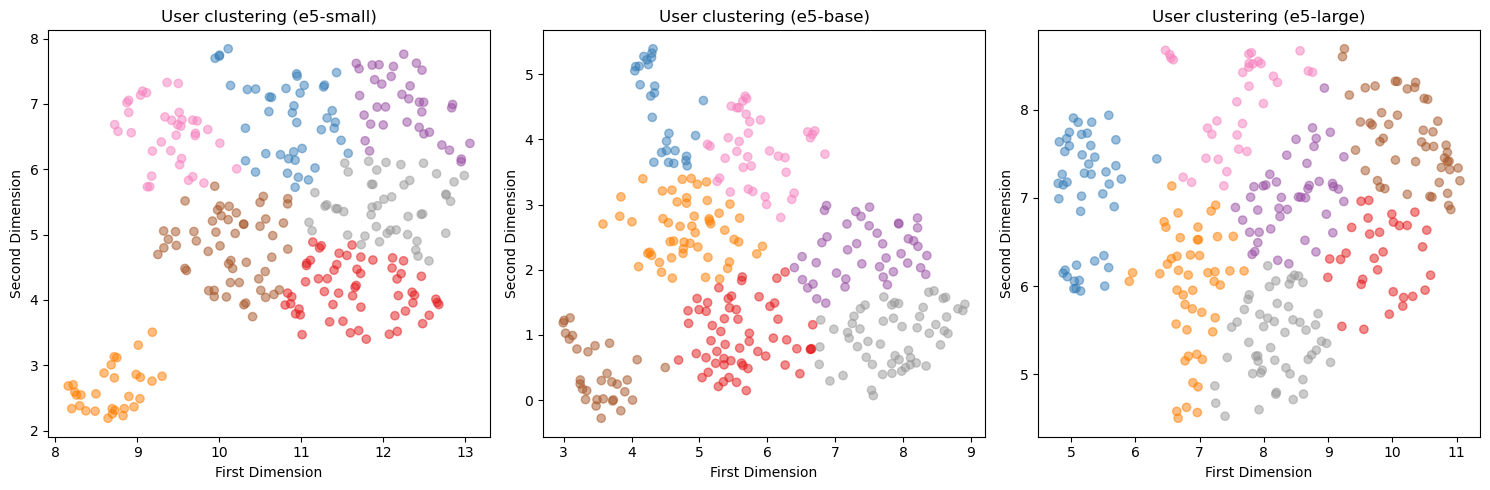

In [88]:
# Tạo hình ảnh và trục (axes) cho UMAP, PCA và t-SNE
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Biểu đồ cho e5small
axes[0].scatter(df_umap_e5small["first_dim"], df_umap_e5small["second_dim"], c=df_umap_e5small["cluster"], cmap='Set1', alpha=0.5)
axes[0].set_title('User clustering (e5-small)')
axes[0].set_xlabel('First Dimension')
axes[0].set_ylabel('Second Dimension')

# Biểu đồ cho e5base
axes[1].scatter(df_umap_e5base["first_dim"], df_umap_e5base["second_dim"], c=df_umap_e5base["cluster"], cmap='Set1', alpha=0.5)
axes[1].set_title('User clustering (e5-base)')
axes[1].set_xlabel('First Dimension')
axes[1].set_ylabel('Second Dimension')

# Biểu đồ cho e5large
axes[2].scatter(df_umap_e5large["first_dim"], df_umap_e5large["second_dim"], c=df_umap_e5large["cluster"], cmap='Set1', alpha=0.5)
axes[2].set_title('User clustering (e5-large)')
axes[2].set_xlabel('First Dimension')
axes[2].set_ylabel('Second Dimension')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [90]:
# List để lưu các chỉ số đánh giá
results = []

# Áp dụng thuật toán KMeans và tính các chỉ số đánh giá cho từng phương pháp giảm chiều
for X_reduce, method in zip([df_umap_e5small, df_umap_e5base, df_umap_e5large], ['E5-small-embedding', 'E5-base-embedding', 'E5-large-embedding']):
    kmeans=KMeans(n_clusters=7,init="k-means++",max_iter=300,n_init=10,random_state=0)
    cluster_labels = kmeans.fit_predict(X_reduce[["first_dim","second_dim"]])
    wcss = kmeans.inertia_
    silhouette_avg = silhouette_score(X_reduce[["first_dim","second_dim"]], X_reduce['cluster'])
    dbi = davies_bouldin_score(X_reduce[["first_dim","second_dim"]], X_reduce['cluster'])
    ch_index = calinski_harabasz_score(X_reduce[["first_dim","second_dim"]], X_reduce['cluster'])  
    results.append((method, wcss, dbi, silhouette_avg, ch_index))

# Tạo DataFrame từ list silhouette_scores
df_evaluation_metrics = pd.DataFrame(results, columns=['Method','WCSS', 'Davies-Bouldin Index', 'Silhouette Score', 'Calinski-Harabaz Index'])
# In DataFrame
df_evaluation_metrics

,Method,WCSS,Davies-Bouldin Index,Silhouette Score,Calinski-Harabaz Index
0,E5-small-embedding,124.646866,0.793123,0.413071,384.866648
1,E5-base-embedding,139.799530,0.800806,0.430464,392.656120
2,E5-large-embedding,144.967651,0.856640,0.399689,344.504712


## ==> Conclude : Using E5-base model for word embedding and apply umap dimensional reduction give the best cluster quality

# 6. Topic modelling (2 - 3 topics for each cluster)

In [47]:
for  i in range(7) :
    list_post_sr = pd.Series(list_post_per_user)
    list_post_sr = list(list_post_sr[df_umap_e5base["cluster"] == i])

    # biểu diễn dưới dạng embedding vectors
    vectorizer = TfidfVectorizer()
    embedding_vectors = vectorizer.fit_transform(list_post_sr)

    # Áp dụng mô hình topic modeling (LDA)

    lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
    lda_model.fit(embedding_vectors)

    # Hiển thị các chủ đề
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        print("Topic ",i,":")
        top_words_idx = topic.argsort()[-20:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(top_words)

Topic  0 :
['tomhank', 'hank', 'lilolov', 'wwwlindsaylohanm', 'tom', 'lindsaycollector', 'hanx', 'asg', 'lindsaylohan', 'hanxian', 'admin', 'lohan', 'ritawilson', 'lindsay', 'tomhanksfan', 'intern', 'bestactor', 'tomhanksfansit', 'wwwlindsaylohanus', 'actor']
Topic  0 :
['thank', 'love', 'kardashian', 'video', 'jenner', 'kyli', 'new', 'night', 'show', 'kim', 'music', 'life', 'kardashianjennernewsupd', 'friend', 'world', 'birthday', 'girl', 'everyon', 'fifth', 'famili']
Topic  1 :
['fantasticohcombeep', 'ronaldo', 'neymar', 'world', 'cristiano', 'team', 'goal', 'nadal', 'player', 'game', 'thank', 'madrid', 'halamadrid', 'deviltim', 'roger', 'peopl', 'que', 'feder', 'manutd', 'messi']
Topic  1 :
['trump', 'biden', 'peopl', 'obama', 'ufc', 'rudo', 'presid', 'anderson', 'bill', 'world', 'nye', 'scienc', 'famili', 'life', 'live', 'cooper', 'donald', 'elect', 'rt', 'america']
Topic  2 :
['music', 'video', 'justin', 'album', 'eminem', 'aaliyah', 'kendrick', 'song', 'fifth', 'normani', 'love',

# 7. Visualize user clusters by posts and their interest topics 

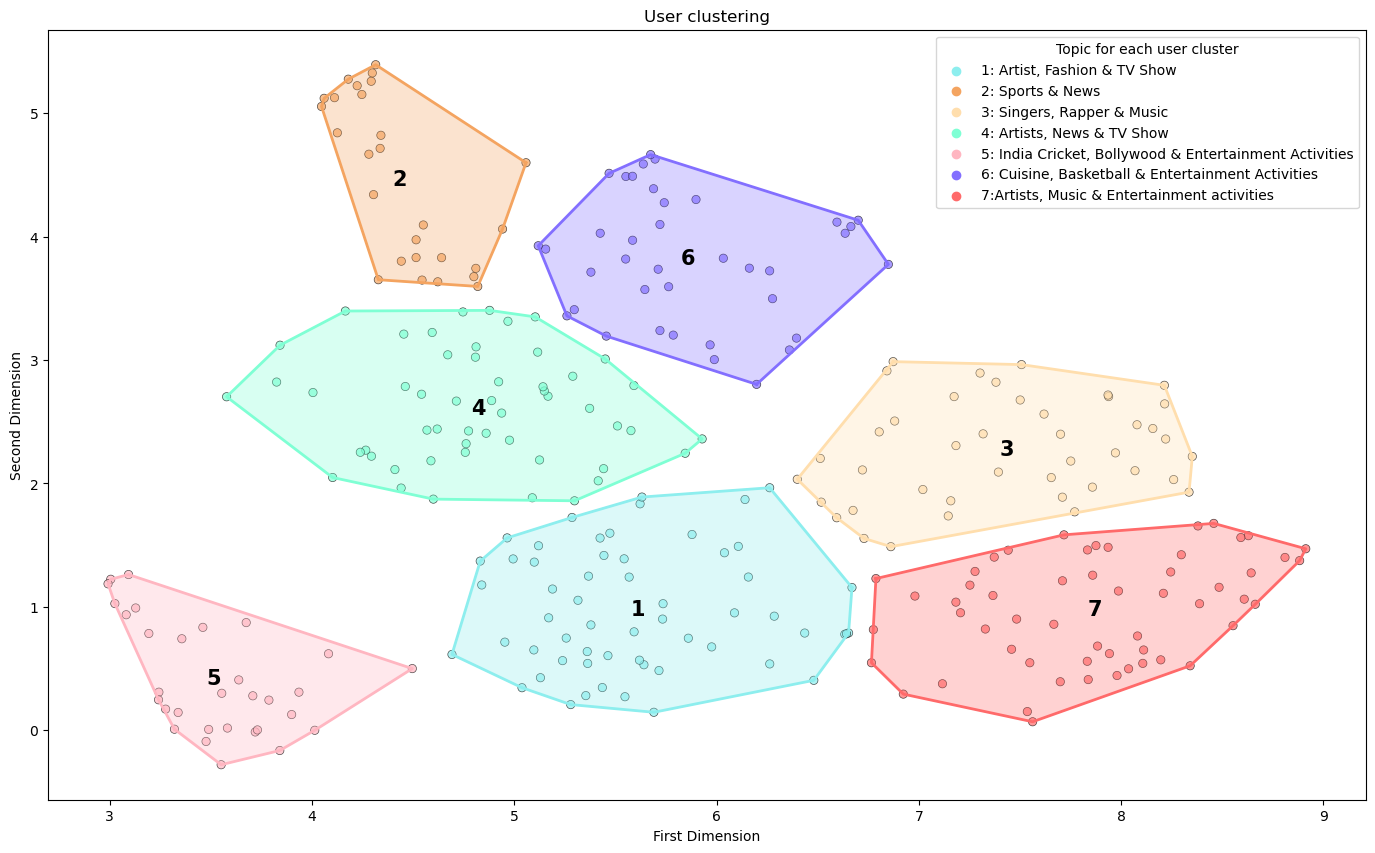

In [102]:
#Tính toán tâm cụm
centers = df_umap_e5base.groupby('cluster')[['first_dim', 'second_dim']].mean().values

# Tạo danh sách các màu tùy chỉnh cho các cụm
custom_colors = ['#8DEEEE', '#F4A460', '#FFDEAD','#7FFFD4','#FFB6C1','#836FFF','#FF6A6A']  # Tùy chỉnh mã màu tại đây

# Vẽ biểu đồ scatterplot
plt.figure(figsize=(17, 10))
scatterplot = sns.scatterplot(data=df_umap_e5base, x='first_dim', y='second_dim', hue='cluster', palette=custom_colors, alpha=0.7, edgecolor='black')

# Lặp qua từng cụm và vẽ đường bao convex hull
for cluster_id, center in enumerate(centers):
    cluster_points = df_umap_e5base[df_umap_e5base['cluster'] == cluster_id][['first_dim', 'second_dim']].values
    hull = ConvexHull(cluster_points)
    hull_points = cluster_points[hull.vertices]
    hull_points = np.vstack((hull_points, hull_points[0]))  # Thêm điểm cuối trùng với điểm đầu tiên
    plt.fill(hull_points[:, 0], hull_points[:, 1], color=custom_colors[cluster_id], alpha=0.3)  # Vẽ màu nền cho đường bao
    plt.plot(hull_points[:, 0], hull_points[:, 1], color=custom_colors[cluster_id], linewidth=2)  # Vẽ đường bao

    # Hiển thị tên cụm với màu tương ứng
    cluster_name = f'{cluster_id + 1}'  # Thay đổi chỉ số tên cụm
    plt.text(center[0], center[1], cluster_name, fontsize=15, fontweight='bold', color="Black", ha='center', va='center')

handles, labels = scatterplot.get_legend_handles_labels()
custom_labels = ['1: Artist, Fashion & TV Show',  '2: Sports & News', '3: Singers, Rapper & Music','4: Artists, News & TV Show','5: India Cricket, Bollywood & Entertainment Activities','6: Cuisine, Basketball & Entertainment Activities','7:Artists, Music & Entertainment activities']  
plt.legend(handles, custom_labels, loc='best',title='Topic for each user cluster')
# Hiển thị biểu đồ
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('User clustering')
plt.show()